## 多层感知机的简洁实现

In [1]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

### 定义网络

In [4]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

net = nn.Sequential(
    d2l.FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

### 读取数据并训练

In [5]:
batch_size = 256    # 每批训练样本数量为256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
# 定义损失
loss = torch.nn.CrossEntropyLoss()
# 优化
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.704, test acc 0.801
epoch 2, loss 0.0019, train acc 0.821, test acc 0.747
epoch 3, loss 0.0017, train acc 0.844, test acc 0.814
epoch 4, loss 0.0015, train acc 0.857, test acc 0.841
epoch 5, loss 0.0014, train acc 0.863, test acc 0.860


In [6]:
torch.cuda.is_available()

True

## 拟合实验

In [7]:
%matplotlib inline

In [8]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
# 进行张量拼接
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
# 计算标签
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
# 添加偏差
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [9]:
# y 轴使用对数尺度
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [10]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)


final epoch: train loss 0.0001039404232869856 test loss 0.00019211556355003268
weight: tensor([[ 1.2077, -3.3972,  5.5978]]) 
bias: tensor([4.9972])


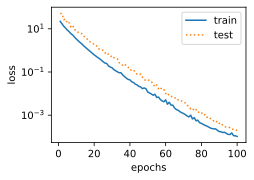

In [11]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], 
            labels[:n_train], labels[n_train:])

final epoch: train loss 109.28235626220703 test loss 337.76446533203125
weight: tensor([[15.8297]]) 
bias: tensor([3.0329])


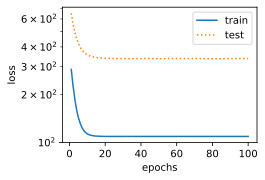

In [12]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

final epoch: train loss 0.33553314208984375 test loss 815.445556640625
weight: tensor([[ 1.6532,  0.8060, -0.2239]]) 
bias: tensor([4.1576])


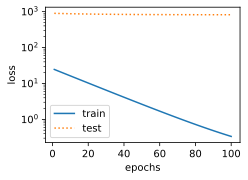

In [13]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])